# Assignment 23
--------------------------------------------------------------------------------

### In this assignment we are going to Align face from a video and detect stabilized landmarks in that video



### Let's first connect to drive to dwonload required data

In [1]:
!pip install -U -q PyDrive
!git clone https://gist.github.com/dc7e60aa487430ea704a8cb3f2c5d6a6.git /tmp/colab_util_repo
!mv /tmp/colab_util_repo/colab_util.py colab_util.py 
!rm -r /tmp/colab_util_repo
from colab_util import *
drive_handler = GoogleDriveHandler()

Cloning into '/tmp/colab_util_repo'...
remote: Enumerating objects: 40, done.
remote: Total 40 (delta 0), reused 0 (delta 0), pack-reused 40
Unpacking objects: 100% (40/40), done.


In [0]:
from google.colab import drive
import cv2
import glob
from skimage import io
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import dlib

In [0]:
def Download_files_from_Drive(FileName,DriveFilepath):
  drive_handler.download(FileName, target_path=DriveFilepath)

def Upload_files_to_Drive(FileName,TargetDrivePath):
  drive_handler.upload(FileName, parent_path=TargetDrivePath)


In [0]:
Download_files_from_Drive('shape_predictor_68_face_landmarks.dat','EVA_Phase_1/Session_26/shape_predictor_68_face_landmarks.dat')
Download_files_from_Drive('shape_predictor_5_face_landmarks.dat','EVA_Phase_1/Session_26/shape_predictor_5_face_landmarks.dat')
Download_files_from_Drive('faceBlendCommon.py','EVA_Phase_1/Session_26/faceBlendCommon.py')

In [0]:
Download_files_from_Drive('VID_2.mp4','EVA_Phase_1/Session_26/VID_2.mp4')

In [0]:
import cv2, dlib
import numpy as np
import math, sys
import faceBlendCommon as fbc
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [0]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

In [0]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [0]:
winName = "Stabilized facial landmark detector"

In [0]:
videoFileName = "VID_2.mp4"

# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
  print("Unable to load video")

In [0]:
winSize = 101
maxLevel = 10
fps = 30.0
# Grab a frame
ret,imPrev = cap.read()

In [13]:
# Finding the size of the image.
size = imPrev.shape
print(size)

(1080, 1920, 3)


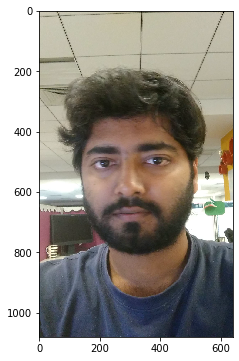

In [14]:
imPrev = cv2.rotate(imPrev, cv2.ROTATE_90_COUNTERCLOCKWISE)
imPrev = cv2.resize(imPrev, (640,1080), interpolation=cv2.INTER_CUBIC)
imPrev = cv2.cvtColor(imPrev, cv2.COLOR_BGR2RGB)
plt.imshow(np.asarray(imPrev))

In [0]:
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [0]:
def get_68_pt_detector(frame, fd= detector, lmd=landmarkDetector):
		points_68 = fbc.getLandmarks(landmarkDetector= lmd, faceDetector=fd, im=frame)
		return np.array(points_68)
  
def drow_circle_points(img, pointsOut):
		imgs  = np.copy(img)
		for (x, y) in pointsOut:
				imgs = cv2.circle(imgs, (x, y), 2, (0, 255, 0), -1)
		return imgs  

In [0]:
# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

In [0]:
eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count =0

In [0]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./stabilize_vdo_v2.avi', fourcc, 15.0, (640,480))
h = 600
w = 400

In [0]:
cap.isOpened()

True

In [45]:
while(cap.isOpened()):
    if (count==0):
        t=cv2.getTickCount()

    #Grabaframe
    ret,im=cap.read()

    if ret==True:
        im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
        points = get_68_pt_detector(frame=im)
        if len(points)==5 or len(points)==68:
            imNorm, points = fbc.normalizeImagesAndLandmarks((h, w), np.float32(im)/255.0, points)
            imNorm = np.uint8(imNorm*255)
            kk = drow_circle_points(imNorm, points)
            cam = np.copy(im)
            im = np.copy(imNorm)
        imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        print(ret)
        # COnverting to grayscale
        imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        height = im.shape[0]
        IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
        # Resize image for faster face detection
        imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
        imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
        # Skipping the frames for faster processing
        if (count % SKIP_FRAMES == 0):
            faces = detector(imSmallDlib,0)
        # If no face was detected
        
        if len(faces)==0:
            print("No face detected")
        # If faces are detected, iterate through each image and detect landmark points
        else:
            print("Face detected")
            for i in range(0,len(faces)):
    #       print("face detected")
                # Face detector was found over a smaller image.
                # So, we scale face rectangle to correct size.
                newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
                    int(faces[i].top() * IMAGE_RESIZE),
                    int(faces[i].right() * IMAGE_RESIZE),
                    int(faces[i].bottom() * IMAGE_RESIZE))

                # Detect landmarks in current frame
                landmarks = landmarkDetector(imDlib, newRect).parts()

                # Handling the first frame of video differently,for the first frame copy the current frame points
                
                if (isFirstFrame==True):
                    pointsPrev=[]
                    pointsDetectedPrev = []
                    [pointsPrev.append((p.x, p.y)) for p in landmarks]
                    [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

                # If not the first frame, copy points from previous frame.
                
                else:
                    pointsPrev=[]
                    pointsDetectedPrev = []
                    pointsPrev = points
                    pointsDetectedPrev = pointsDetectedCur

                # pointsDetectedCur stores results returned by the facial landmark detector
                # points stores the stabilized landmark points
                points = []
                pointsDetectedCur = []
                [points.append((p.x, p.y)) for p in landmarks]
                [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

                # Convert to numpy float array
                pointsArr = np.array(points,np.float32)
                pointsPrevArr = np.array(pointsPrev,np.float32)

                # If eye distance is not calculated before
                if eyeDistanceNotCalculated:
                    eyeDistance = interEyeDistance(landmarks)
    #         print(eyeDistance)
                    eyeDistanceNotCalculated = False
                
                if eyeDistance > 100:
                    dotRadius = 3
                else:
                    dotRadius = 2

    #       print(eyeDistance)
                sigma = eyeDistance * eyeDistance / 400
                s = 2*int(eyeDistance/4)+1

                #  Set up optical flow params
                lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
                # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
    #       ret, imGrayPrev= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)
    #       print(imDlib.shape,imGray.shape)
                pointsArr,status, err = cv2.calcOpticalFlowPyrLK(im,imDlib,pointsPrevArr,pointsArr,**lk_params)


                # Converting to float
                pointsArrFloat = np.array(pointsArr,np.float32)

                # Converting back to list
                points = pointsArrFloat.tolist()

                # Final landmark points are a weighted average of
                # detected landmarks and tracked landmarks
                for k in range(0,len(landmarks)):
                    d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
                    alpha = math.exp(-d*d/sigma)
                    points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

                # Drawing over the stabilized landmark points
                if showStabilized is True:
                    for p in points:
                        cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
                else:
                    for p in pointsDetectedCur:
                        cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)
                        
                isFirstFrame = False
                count = count+1

                # Calculating the fps value
                if ( count == NUM_FRAMES_FOR_FPS):
                    t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
                    fps = NUM_FRAMES_FOR_FPS/t
                    count = 0
                    isFirstFrame = True

                # Display the landmarks points
                cv2.putText(im, "{:.1f}-fps Stabilization".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 255), 3,cv2.LINE_AA)
                cv2.putText(kk, "Without Stabilization", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 0.9, (0, 255, 0), 3,cv2.LINE_AA)
                cv2.putText(cam, "   Original", (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255, 255, 255), 3,cv2.LINE_AA)
            #   cv2.imshow(winName, im)
                cam = cv2.resize(cam, (400,600))
    #             print(cam.shape)
                im = np.concatenate([cam, kk,im], axis=1)
                final_out = cv2.resize(im, (640, 480))
                #cv2_imshow(final_out)
                out.write(final_out)
            #   frame = cv2.flip(frame,0)
            # write the flipped frame
                # if frame.shape == (480, 640, 3) and final_out.shape == (480, 640, 3):
                # 	out.write(final_out)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    showStabilized = not showStabilized
                imPrev = im
                imGrayPrev = imGray
                # Use spacebar to toggle between Stabilized and Unstabilized version.

                # Stop the program.
        if cv2.waitKey(1) & 0xFF == ord(' '):
            break
                # Getting ready for next frame
    else:
        cap.release()
        out.release()
        # cv2.destroyAllwindows()
						


True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face detected
True
Face de

In [0]:
# cap.release()
# out.release()
#cv2.destroyAllwindows()